In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import import_ipynb
import PortfolioHelper

In [2]:
ltcm_ret = pd.read_excel("./data/ltcm_exhibits_data.xlsx",sheet_name= "Exhibit 2",skiprows=lambda x: x in np.arange(0,3),index_col=0).dropna()
ltcm_ret.columns = ['Fund Capital','Gross Monthly Performance','Net Monthly Performance','Index of Net Performance']
ltcm_lev = pd.read_excel("./data/ltcm_exhibits_data.xlsx",sheet_name= "Exhibit 4",skiprows=lambda x: x in np.arange(0,2),index_col=0).dropna()
rf = pd.read_excel("./data/gmo_analysis_data.xlsx",sheet_name= "risk-free rate",index_col = 0)/12
spy = pd.read_excel("./data/gmo_analysis_data.xlsx",usecols = "A:B",sheet_name= "total returns",index_col = 0)

2.1

In [4]:
ltcm_ret.index = ltcm_ret.index.map(lambda x: pd.to_datetime(x)).to_period("M")
ltcm_lev.index = ltcm_lev.index.map(lambda x: pd.to_datetime(x)).to_period("M")

rf.index = rf.index.to_period("M")
spy.index = spy.index.to_period("M")

rf = rf.loc[(ltcm_ret.index[0]<=rf.index) & (rf.index<=ltcm_ret.index[-1])]
spy = spy.loc[(ltcm_ret.index[0]<=spy.index) & (spy.index<=ltcm_ret.index[-1])]


In [77]:
ltcm_ret.index[-1]
# cumulate returns

Period('1998-07', 'M')

In [5]:
ltcm_eret = ltcm_ret.copy()
ltcm_eret[['Gross Monthly Performance','Net Monthly Performance']] = ltcm_eret[['Gross Monthly Performance','Net Monthly Performance']].apply(lambda x:x-rf['TBill 3M'])

espy = spy.copy()
espy = (espy['SPY']-rf['TBill 3M']).to_frame(name='SPY')

In [6]:
ltcm_perf = PortfolioHelper.performance_summary(ltcm_eret[['Gross Monthly Performance', 'Net Monthly Performance']])
spy_perf = PortfolioHelper.performance_summary(espy)
total_perf = pd.concat([ltcm_perf,spy_perf],axis=0)
total_perf

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
Gross Monthly Performance,0.243347,0.136271,1.785754,-0.289726,1.579963,-0.030368,-0.072964,-0.105133,0.112267,-0.168803,1998-04,1998-06,NaT
Net Monthly Performance,0.156630,0.111808,1.400890,-0.811719,2.917247,-0.026388,-0.068631,-0.105133,0.080267,-0.175433,1997-12,1998-07,NaT
SPY,0.175249,0.112696,1.555053,-0.432539,-0.358694,-0.046639,-0.051699,-0.055928,0.074980,-0.055928,1997-07,1997-08,1997-12


Gross and net monthly performance show similar Sharpe ratio compared to the market and slightly better VaR level but they were exposed to greater CvaR risk meaning that they exposed themselves to greater tail risk as can be seen in maximum drawdown as well.

2.2

In [9]:
ltcm_ts_regr = PortfolioHelper.time_series_regression(ltcm_eret[['Net Monthly Performance']],factors= espy[['SPY']])
ltcm_ts_regr

<string>:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<string>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Net Monthly Performance,0.132603,0.137101,1.197485,1.142446,0.019097,0.110735


b) LTCM doesn't appear to be a close indexer as can see in low r-squared which is closer to only 2%. 

c) LTCM do deliver excess return over what can be explained my exposure to market, positive alpha is the strong evidence to it.

2.3

In [12]:
regressors = pd.concat([espy['SPY'],espy[['SPY']].apply(lambda x: x**2)],axis=1)
regressors.columns = ['SPY','SPY^2']
ltcm_ts_nl_regr = PortfolioHelper.calc_multivariate_regression(ltcm_eret[['Net Monthly Performance']],regressors)
ltcm_ts_nl_regr

<string>:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,Alpha,R-Squared,SPY Beta,SPY^2 Beta,Information Ratio,Tracking Error
Net Monthly Performance,0.156279,0.024539,0.167321,-1.928874,1.415224,0.110427


b) Quadratic part which attempts to capture nonlinear exposure to market doesn't add much value to the r^2. R^2 only incresed from around 2% to 2.5%

c) If we were to claim its similar to long market option then we should see high beta to the market and r^2 which regression statistics doesn't support. Moreover graph plotting its monthly return shows that is closer to short market options

d) LTCM should be regarded as negatively exposed to market volatility as it was vol seller and the graph below describing its returns on rolling standard deviation supports it 

In [14]:
np.corrcoef(espy['SPY'],ltcm_eret['Net Monthly Performance'])

array([[1.        , 0.13819062],
       [0.13819062, 1.        ]])

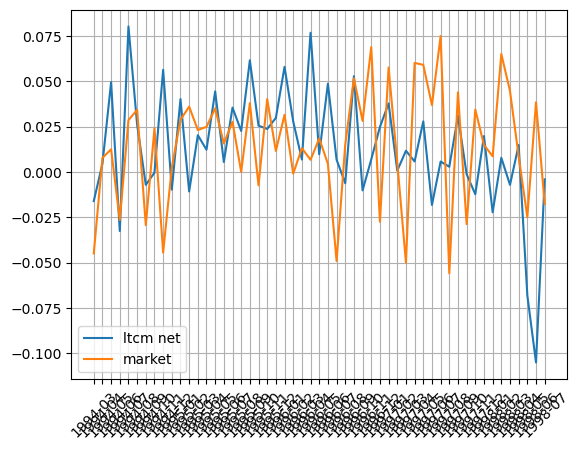

In [15]:
import matplotlib.pyplot as plt 
plt.plot(ltcm_eret.index.astype(str),ltcm_eret['Net Monthly Performance'],label = 'ltcm net')
plt.plot(espy.index.astype(str),espy['SPY'],label = 'market')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc=0)

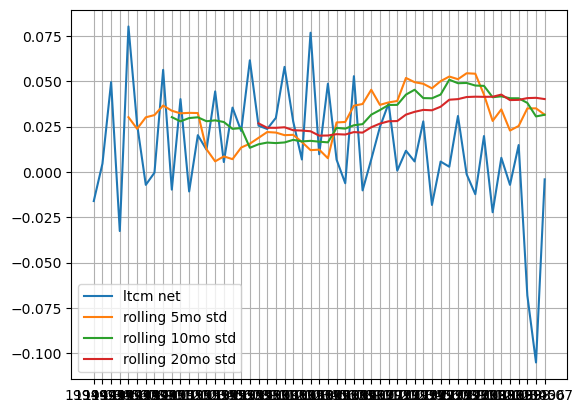

In [16]:
plt.plot(ltcm_eret.index.astype(str),ltcm_eret['Net Monthly Performance'],label = 'ltcm net')
plt.plot(espy.index.astype(str),espy['SPY'].rolling(5).std(),label = 'rolling 5mo std')
plt.plot(espy.index.astype(str),espy['SPY'].rolling(10).std(),label = 'rolling 10mo std')
plt.plot(espy.index.astype(str),espy['SPY'].rolling(20).std(),label = 'rolling 20mo std')
plt.grid(True)
plt.legend(loc=0)

2.4

In [18]:
option_factors = pd.concat([espy['SPY'].apply(lambda x: max(x-0.03,0)),espy['SPY'].apply(lambda x: max(-0.03-x,0))],axis=1)
option_factors.columns = ['Call-like','Put-like']
option_regr = PortfolioHelper.calc_multivariate_regression(ltcm_eret[['Net Monthly Performance']],option_factors)
option_regr

<string>:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,Alpha,R-Squared,Call-like Beta,Put-like Beta,Information Ratio,Tracking Error
Net Monthly Performance,0.157025,0.000635,0.030535,-0.118904,1.404869,0.111772


b) LTCM is closer to selling call-like factor as the return is positive covariation with call like beta. Under uptrend market condition volatiliy tends to decrease which is a favorable condition for volatility sellers.

c) Put-like factor moves LTCM more as it has 4times bigger coefficient(we can interpret in this way since the scale is the same). Intrepreting this, under distressed financial condition where volatiliy tends to spike, volatility sellers suffer huge losses.

d) LTCM is negatively exposed to volatiliy and is similar to short straddle position this can also be seen as long market and short downside at the same time.

3.

In [81]:
rfr = pd.read_excel("./data/fx_rf_data.xlsx",sheet_name= "risk-free rates",index_col = 0).apply(lambda x: np.log(1+x)/252) # annualized 
exchange_rates = pd.read_excel("./data/fx_rf_data.xlsx",sheet_name= "exchange rates",index_col = 0).apply(lambda x: np.log(x)).ffill()



3.1 Static Carry Trade

In [83]:
elog_ret = (exchange_rates.diff()+ rfr[rfr.columns.difference(['USD'])].shift(1)).apply(lambda x: x-rfr['USD'].shift(1)).dropna()
PortfolioHelper.performance_summary(elog_ret,annualization=252)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
CHF,0.002654,0.106870,0.024837,5.134798,169.528298,-0.009193,-0.013353,-0.090926,0.194949,-0.418179,2011-08-09,2022-11-03,NaT
EUR,-0.023540,0.090053,-0.261398,0.108585,2.361478,-0.008957,-0.012918,-0.024266,0.034517,-0.481911,2008-04-22,2022-09-27,NaT
GBP,-0.024848,0.095667,-0.259732,-0.830625,11.313299,-0.009312,-0.014026,-0.083953,0.030998,-0.509594,2008-03-13,2022-09-26,NaT
JPY,-0.029353,0.099113,-0.296154,0.115773,5.355791,-0.009561,-0.014237,-0.054782,0.038371,-0.623242,2011-10-28,2024-07-10,NaT
MXN,0.011130,0.129950,0.085649,-0.703794,7.804878,-0.012716,-0.019643,-0.079347,0.066751,-0.414436,2008-08-04,2017-01-19,2023-06-09


An FX Carry trade on CHF and MXN generates positive mean excess return for the sample period and thus, positive sharpe. For the other 3, they all have negative mean and sharpe ratio

3.2 Implications for UIP

1. No single mean of above analysis shows mean return that is 0 thus, UIP doesn't hold.

2. Long position in MXN peso yield the best Sharpe ratio over the sample, slightly over 0.1 Sharpe.

3. EUR, GBP, JPY earned a negative excess return over the sample.

3.3 Predicting FX

In [36]:
erfr = rfr.apply(lambda x: rfr['USD']-x)

In [38]:
forecast_df = pd.DataFrame()

for i in exchange_rates.columns:
    # print(i)
    forecast_regr = PortfolioHelper.calc_univariate_regression(exchange_rates.loc[:,i].diff().dropna(),erfr.loc[:,i].shift(1).iloc[1:])
    forecast_df = pd.concat([forecast_df,forecast_regr],axis=0)

In [39]:
forecast_df = forecast_df.filter(items =['Alpha','Beta','R-Squared']).T
forecast_df

,JPY,EUR,GBP,MXN,CHF
Alpha,-0.001042,-0.001501,-0.001201,-0.003478,0.000176
Beta,0.351755,2.160192,6.810272,-0.794273,0.906945
R-Squared,0.000013,0.000298,0.001537,0.000020,0.000050


In [40]:
erfr.mean()*252

USD    0.000000
JPY    0.011848
EUR    0.006804
GBP    0.000067
MXN   -0.047915
CHF    0.013081
dtype: float64

a) Expect relative strengthening of USD over Mexican Peso as UIP claims that the amount you earn from difference between risk free rate is then offsetted by that currency's depreciation.

b) JPY, EUR, GBP, CHF is the currency with lower risk free rate thus, UIP will argue that this currency must appreciate relative to USD on average.

c) It is strongest among GBP but r^2 is so low that we cannot really say it has predictability on the next day. 

3.4 The Dynamic Carry Trade

In [45]:
forecast_df.loc['Alpha']

JPY   -0.001042
EUR   -0.001501
GBP   -0.001201
MXN   -0.003478
CHF    0.000176
Name: Alpha, dtype: float64

In [66]:
erfr.head()

,USD,JPY,EUR,GBP,MXN,CHF
date,,,,,,
2008-01-01,0.0,0.000156,0.000006,-0.000052,-0.000123,0.000093
2008-01-02,0.0,0.000146,0.000022,-0.000052,-0.000133,0.000083
2008-01-03,0.0,0.000153,0.000016,-0.000050,-0.000125,0.000087
2008-01-04,0.0,0.000148,0.000006,-0.000051,-0.000130,0.000084
2008-01-07,0.0,0.000148,0.000005,-0.000049,-0.000130,0.000087


In [68]:
exp_ret = erfr.iloc[:,1:].apply(lambda x:forecast_df.loc['Alpha']+(forecast_df.loc['Beta']-1)*x,axis=1)
exp_ret.head()

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2008-01-01,-0.001143,-0.001494,-0.001501,-0.003257,0.000168
2008-01-02,-0.001136,-0.001475,-0.001505,-0.003240,0.000169
2008-01-03,-0.001141,-0.001482,-0.001490,-0.003254,0.000168
2008-01-04,-0.001138,-0.001494,-0.001497,-0.003245,0.000168
2008-01-07,-0.001138,-0.001495,-0.001487,-0.003245,0.000168


In [74]:
positive_counts = (exp_ret > 0).sum()
negative_counts = (exp_ret < 0).sum()

result = pd.DataFrame({'Positive Count': positive_counts, 'Negative Count': negative_counts})

print(result)

     Positive Count  Negative Count
JPY               0            4393
EUR               0            4393
GBP               0            4393
MXN               0            4393
CHF            4393               0


2. CHF has positive FX risk premium and every currency besides CHF eqally go to negative.

3. Buy CHF sell USD/CHF fwd.